In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time, os, sys, pickle
import seaborn as sns
from tqdm import tqdm
import svgutils.compose as sc
import IPython.display as ip
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=sns.color_palette('colorblind'))

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import bptt_rnn as bp  # RNN, learning algorithm, loss function etc
import plot_routines as pr  # plotting functions & directly related
import rot_utilities as ru  # random utilies

%load_ext autoreload
%autoreload 2

In [2]:
single_time_labels = ['0', 'A', '0', 'B', '0', 'C', '0', 'D', '0']
double_time_labels = []
double_time_labels_half = []
for stl in single_time_labels:
    double_time_labels.append(stl)
    double_time_labels.append(stl)
    double_time_labels_half.append(stl)
    double_time_labels_half.append('')
double_time_labels_blank = [x.replace('0', '') for x in double_time_labels]
single_time_labels_blank = [x.replace('0', '') for x in single_time_labels]
assert len(double_time_labels_half) == len(double_time_labels)

##  Task design

Trials consist of a sequence: 

$ A_{\alpha} \to B_{\alpha} \to C_{\beta} \to D$, where $\alpha, \beta \in (1, 2)$

Stimuli are interleaved with blanks $0$; e.g. $seq = (z_0, z_1, z_2, ... , z_8) = ( 0, A_{\alpha}, 0, B_{\alpha}, 0, C_{\beta}, 0, D, 0 )$
Sequences can either be <em>expected</em>: $\alpha = \beta$ (the majority of trials) or <em>unexpected</em> $\alpha \neq \beta$ (remainder or trials).

We train a neural network to predict the next stimulus $z_{t+1}$ given the current stimulus $z_t$.

## Create synthetic data
There are 8 possible values: 
- 0 $blank/0$
- 1 $A_1$
- 2 $A_2$
- 3 $B_1$
- 4 $B_2$
- 5 $C_1$
- 6 $C_2$
- 7 $D$

Data points are thus 8-dim vectors, with:

$z_{k, t} = (1_{0}, 1_{A_1}, 1_{A_2}, ... , 1_{D})$

where $k$ is the trial index, and $t$ is the trial time. Hence $|z_{k, t}| = 1 $. The goal of the task is to predict $z_{k, t+1}$ given its own state and $z_{k, t}$.

Trials will be either $T=9$ data points long (single), and of form:

$ 0, A_{\alpha}, 0, B_{\alpha}, 0, C_{\beta}, 0, D, 0 $

or of length $T=18$ (double), and of form:

$ 0, 0, A_{\alpha}, A_{\alpha}, 0, 0, B_{\alpha}, B_{\alpha}, 0, 0, C_{\beta}, C_{\beta}, 0, 0, D, D, 0, 0 $

where $\alpha, \beta \in (1, 2)$, although one can use shorter sequences for testing (e.g. $0, A_{\alpha}, 0, B_{\alpha}, 0$). The expected sequence is $\alpha = \beta$, and the unexpected sequence is $\alpha \neq \beta$.

Network input $x_k = z_{k, 0:T-1} + \epsilon$ and output $y_k = z_{k, 1:T}$, where $\epsilon \sim N(0, \sigma_x)$.

In [3]:
d_dict = {  # data parameters dictionary
        'n_total': 1000,  # total number of data sequences
        'n_freq': 8,  # blank through D
        'n_times': 9,
        'doublesse': True,
        'ratio_train': 0.8,
        'ratio_exp': 0.75,  # probabilities of switching between alpha nd beta
        'noise_scale': 0.15
        }
if d_dict['doublesse']:
    eval_times = np.arange(4, 17)  # double
    d_dict['sequence'] = np.array(double_time_labels)
elif d_dict['doublesse'] is False:
    eval_times = np.arange(1, 8)  # single
    d_dict['sequence'] = np.array(single_time_labels)
t_dict = {'eval_times': eval_times}  # training paramter dictionary

freq_labels = ['0', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'D']
freq_labels_sub = [r"$0$", r"$A_1$", r"$A_2$", r"$B_1$", r"$B_2$", r"$C_1$", r"$C_2$", r"$D$"]
freq_labels_sub_mnm = [r"$0$", r"$A_1$", r"$A_2$", r"$B_1$", r"$B_2$", r"$C_1$", r"$C_2$", r"$D$", 'M', 'NM']
tmp0, tmp1 = bp.generate_synt_data(n_total=d_dict['n_total'], 
                                   n_times=d_dict['n_times'], 
                                   n_freq=d_dict['n_freq'],
                                   ratio_train=d_dict['ratio_train'], 
                                   ratio_exp=d_dict['ratio_exp'], 
                                   noise_scale=d_dict['noise_scale'], 
                                   double_length=d_dict['doublesse'])
x_train, y_train, x_test, y_test = tmp0
labels_train, labels_test = tmp1

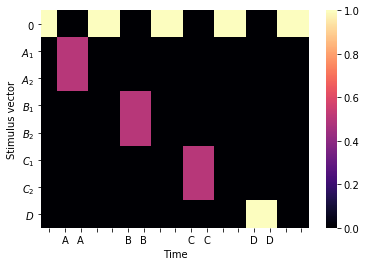

In [4]:
# x_train[:, :, 0] = 0
# x_test[:, :, 0] = 0
# y_train[:, :, 0] = 0
# y_test[:, :, 0] = 0
pr.plot_example_trial(y_train.mean(0))

## RNN Model with BPTT

#### RNN model:

$(x_t, r_{t-1}) \to r_t \to \hat{y}_t == y_t = x_{t+1} $

within one trial $k$. 
Equations:

$r_t = \tanh( U \cdot x_t + W \cdot r_{t-1})$


$\hat{y}_t = softmax(V \cdot r_t) = \left( \frac{e^{V_i \cdot r_t}}{\sum_i e^{V_i \cdot r_t}} \right), \; for \; i \in (0, A_1, A_2 ... D)$

where $U_{n x f}, W_{n x n}, V_{f x n}$ are matrices where $n$ is the number of RNN nodes and $f$ the number of input/output frequencies.

#### Training procedure:

The full sequence $x_k$ is forwarded through the model, yielding $\hat{y}_k$. This is used to compute the loss function $L$, which error is backpropagated through time (BPTT) to the parameters $\theta = (U, W, V)$ (updated with SGD probably). 
The loss function $L$ uses cross entropy and L1 regularisation:

$L_k = \sum_{\tau} - y_{k, \tau} \log \hat{y}_{k, \tau} + \lambda \cdot ||\theta||_1$

where $\tau$ defines the trial times that are taken into account for Loss computation. We set $\tau$ to all trial times _after_ the $A_{\alpha}$ stimuli have occured.

<!-- $ \begin{equation}
    \tau =
    \begin{cases}
      (0, 1, 2, ... 8), & \text{all} \\
      (1, 3, 5, 7), & \text{non-blank (nb)}\\
      (3, 5, 7), & \text{non-initial nb (ninb)}
    \end{cases}
  \end{equation}$
-->
#### Initial conditions:

We initialise $s_0$ with random values drawn from $N(0, 0.1)$ (for each trial individually).


#### Pseudo-algorithm:

    for $it$ in epochs:
        for $k$ in trials:
            for $t$ in times:
                rnn.forward($x_t$)
            compute loss $L_k$
            update parameters with BPTT


In [261]:
## Set training parameters:
t_dict['n_nodes'] = 20  # number of nodes in the RNN 
if d_dict['doublesse']:
    t_dict['learning_rate'] = 0.002  # algorithm lr
elif d_dict['doublesse'] is False:
    t_dict['learning_rate'] = 0.05
t_dict['bs'] = 1  # batch size
t_dict['n_epochs'] = 40  # training epochs
t_dict['l1_param'] = 5e-3  # L1 regularisation in loss function
t_dict['check_conv'] = False  # check for convergence (and abort if converged)
t_dict['conv_rel_tol'] = 5e-4  # assess convergence by relative difference between two epochs is smaller than this 


In [256]:
1- y_train[:, :, 1]

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [1., 0., 0.,  ..., 1., 1., 1.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

## Train one single model

In [257]:
## Initiate RNN model
rnn = bp.RNN_MNM(n_stim=d_dict['n_freq'], n_nodes=t_dict['n_nodes'], accumulate=True)  # Create RNN class
opt = torch.optim.SGD(rnn.parameters(), lr=t_dict['learning_rate'])  # call optimiser from pytorhc
rnn.set_info(param_dict={**d_dict, **t_dict})

In [258]:
## Train with BPTT
rnn = bp.bptt_training(rnn=rnn, optimiser=opt, dict_training_params=t_dict,
                        x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test,
                       labels_train=labels_train, labels_test=labels_test)

Epoch 19/20. Train loss: 6.009062: 100%|██████████| 20/20 [02:35<00:00,  7.79s/it]     

Training finished. Results saved in RNN Class


In [252]:
# rnn.save_model(folder='models/')

RNN-MNM model saved as rnn-mnm_2020-07-07-1650.data


In [272]:
rnn = ru.load_rnn('models/75-25_MNM_Xmodels/non-accumulate/rnn-mnm_2020-07-08-0124.data')

torch.Size([17, 8])


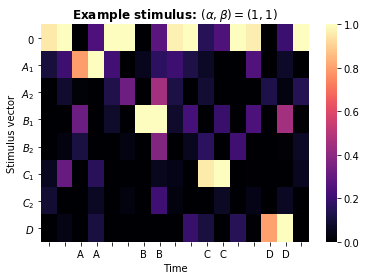

In [273]:
plt.rcParams['figure.figsize'] = (6, 4)
k = 0

print(x_test[k, :, :].shape)
# x_test[k, np.array([2, 3]), 1] = 0
# x_test[k, np.array([2, 3]), 7] = 1
# x_test[k, np.array([6, 7]), 3] = 0
# x_test[k, np.array([6, 7]), 7] = 0
pr.plot_example_trial(x_test[k, :, :], xticklabels=double_time_labels_blank[:-1])
plt.title(r"Example stimulus: $(\alpha, \beta) = (1, 1)$", weight='bold')
plt.savefig('figures/example_stim.pdf', bbox_inches='tight')

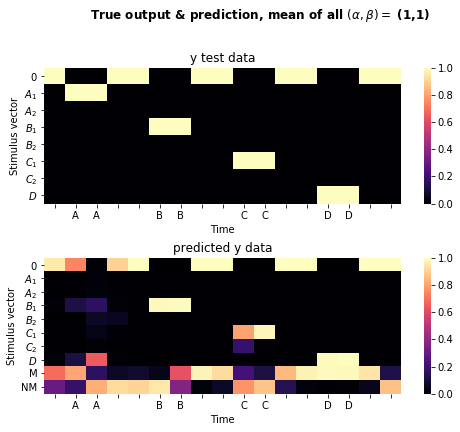

In [275]:
## Plot example test sample & prediction
k = np.where(labels_test == '11')[0]
# print(f'Trial type: {labels_test[k]}')
pred = bp.compute_full_pred(x_test[k,:,:], model=rnn)  # computed forward predictions

plt.rcParams['figure.figsize'] = (8,6 )
plt.subplots_adjust(hspace=0.4)
ax_true = plt.subplot(211)
true_data = y_test[k, :, :]
if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
pr.plot_example_trial(true_data.numpy(), ax=ax_true,
            xticklabels=double_time_labels_blank[1:])
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

ax_pred = plt.subplot(212)
if rnn.lin_output.out_features > rnn.n_stim:
    pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
                          yticklabels=freq_labels_sub_mnm,
               xticklabels=double_time_labels_blank[1:])  # average if multiple samples
else:
    pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
               xticklabels=double_time_labels_blank[1:])  # average if multiple samples
ax_pred.set_title("predicted y data"); #ax_pred.set_ylabel("Predictions");

plt.suptitle(r"True output & prediction, mean of all $(\alpha, \beta) =$ (" + labels_test[k][0][0] + ',' + labels_test[k][0][1] + ')', 
             weight='bold', y=1.02);
# plt.savefig('figures/prediction_unexpected.pdf', bbox_inches='tight')

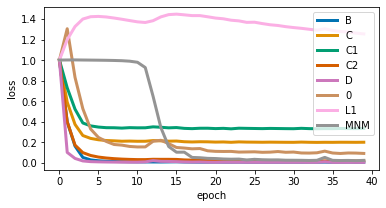

In [276]:
plt.rcParams['figure.figsize'] = (6, 3)
for key, arr in rnn.test_loss_split.items():
    if '_' not in key:
        arr = np.array(arr)
        arr /= arr[0]
        plt.plot(arr, label=key, linewidth=3)
plt.legend()
plt.xlabel('epoch'); plt.ylabel('loss');

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


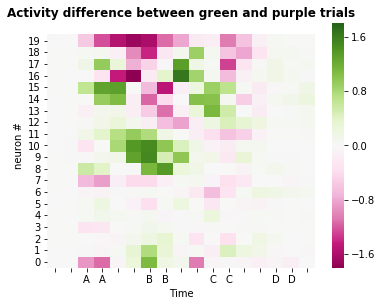

In [277]:
_, __, forw  = bp.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5, sparsity_c=0.1)
labels_use_1 = np.array([x[0] == '1' for x in forw['labels_test']])
labels_use_2 = np.array([x[0] == '2' for x in forw['labels_test']])
plt.rcParams['figure.figsize'] = (6, 4.5)
# plt.rcParams['font.size'] = 10
ax_hm = plt.subplot(111)
ol = pr.plot_raster_trial_average(forw=forw, ax=ax_hm)

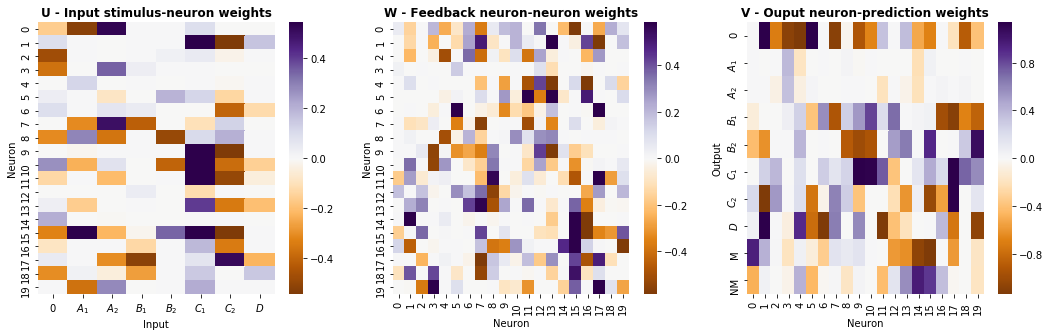

In [278]:
## Plot weight matrices U, W, V
plt.rcParams['figure.figsize'] = (18, 5)
w_order = pr.opt_leaf(w_mat=rnn.lin_input, dim=0)
_ = pr.plot_all_UWV(rnn_model=rnn, freq_labels=freq_labels_sub_mnm, weight_order=ol)

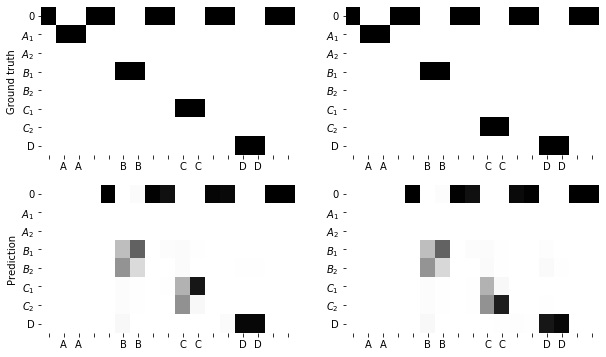

In [50]:
## Plot example test sample & prediction
trial_inds = {'exp': np.where(labels_test == '11')[0],
              'unexp': np.where(labels_test == '12')[0]}
plt.rcParams['figure.figsize'] = (10, 6)
pred, true, ax_pred, ax_true = {}, {}, {}, {}
i_col = 0
for tt, inds in trial_inds.items():
    pred[tt] = bp.compute_full_pred(x_test[inds,:,:], model=rnn)  # computed forward predictions
    true[tt] = y_test[inds, :, :]
    assert len(inds) > 1  # multiple inds
    true[tt] = true[tt].mean(0).numpy()
    pred[tt] = pred[tt].mean(0).detach().numpy()
    zero_inds = np.array(list(set(np.arange(pred[tt].shape[0])).difference(set(t_dict['eval_times']))))
    pred[tt][zero_inds, :] = 0

    ax_true[tt] = plt.subplot(2, 2, 1 + i_col)
    ax_pred[tt] = plt.subplot(2, 2, 3 + i_col)
    pr.plot_example_trial(true[tt], ax=ax_true[tt], c_map='Greys', print_labels=False, c_bar=False)
#     ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')
    pr.plot_example_trial(pred[tt], ax=ax_pred[tt], c_map='Greys', print_labels=False, c_bar=False)  # average if multiple samples
#     ax_pred.set_title("predicted y data"); #ax_pred.set_ylabel("Predictions");
#     plt.suptitle(r"True output & prediction, mean of all $(\alpha, \beta) =$ (" + labels_test[k][0][0] + ',' + labels_test[k][0][1] + ')', weight='bold', y=1.02);

    if i_col == 0:
        ax_true[tt].set_ylabel('Ground truth')
        ax_pred[tt].set_ylabel('Prediction')
    
    # plt.savefig('figures/prediction_unexpected.pdf', bbox_inches='tight')
    i_col += 1

## Cross temporal decoding

Each sequence $seq_k$ has labels $\alpha, \beta$. We wish to decode $\alpha$ dynamically per time point, in a cross-temporal manner, from the RNN hidden state $s_t$. Id est, we create a decoder $dec(t | \tau) = P(\alpha = 1 | \tau)_t$ that is trained at time $\tau$ but evaluated at time $t$. We can choose to train our decoder with either or both $(\alpha = \beta)$ and $(\alpha \neq \beta)$ sequences. To decode, we will use a logistic regression with L1 regularisation (from sklearn). 

#### Pseudocode

    forward run of all trials
    for $\tau$ in T:
        train P($\alpha$ | $\tau$)
        for t in T:
            evaluate P($\alpha$ | $\tau$)_t

In [190]:
score_mat, decoder_dict, forw = bp.train_single_decoder_new_data(rnn=rnn)

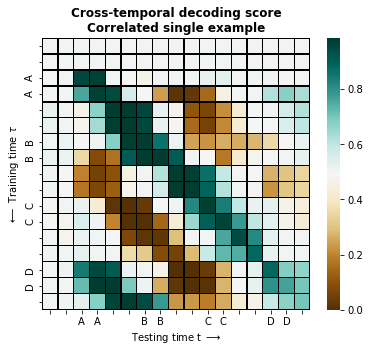

In [191]:
# score_mat[0, 5] = -10
plt.rcParams['figure.figsize'] = (6, 5)
ax_score = pr.plot_decoder_crosstemp_perf(score_matrix=score_mat, ax=plt.subplot(111),
                               ticklabels=double_time_labels_blank[:-1])

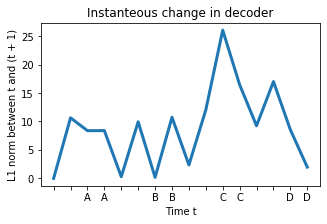

In [35]:
angle_change = np.zeros(x_train.shape[1] - 1)
for tau in range(x_train.shape[1] - 1):
    angle_change[tau] = np.sum(np.abs(decoder_dict[tau].coef_ - decoder_dict[tau + 1].coef_))
    
plt.rcParams['figure.figsize'] = (5, 3)
f, ax_ac = plt.subplots(1, 1)
ax_ac.plot(angle_change, linewidth=3)
ax_ac.set_xlabel('Time t'); ax_ac.set_ylabel('L1 norm between t and (t + 1)')
ax_ac.set_title('Instanteous change in decoder')
ax_ac.set_xticks(np.arange(len(angle_change)));
ax_ac.set_xticklabels(double_time_labels_blank[:-2]);

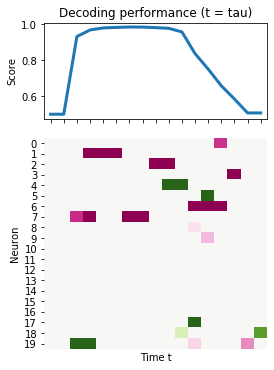

In [36]:
plt.rcParams['figure.figsize'] = (4, 6)
_, __ = pr.plot_dynamic_decoding_axes(rnn=rnn)

## Train & save multiple models

In [5]:
## N nodes sweep:

# for n_nodes in range(2, 25):
#     print(f'\n-----\n{n_nodes}\n----\n')
#     t_dict['n_nodes'] = n_nodes
#     for i_sim in range(5):
#         ## Initiate RNN model
#         rnn = bp.RNN(n_stim=d_dict['n_freq'], n_nodes=t_dict['n_nodes'])  # Create RNN class
#         opt = torch.optim.SGD(rnn.parameters(), lr=t_dict['learning_rate'])  # call optimiser from pytorhc
#         rnn.set_info(param_dict={**d_dict, **t_dict})
#         rnn = bp.bptt_training(rnn=rnn, optimiser=opt, dict_training_params=t_dict,
#                 x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)
#         score_mat, decoder_dict, _ = bp.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5,
#                                                             n_samples=None, ratio_train=0.8, verbose=False)
#         rnn.save_model(folder='models/75-25_ChangingNNodes_Xmodels/', add_nnodes=True)

# ns_folder = '/home/thijs/repos/rotation/models/75-25_ChangingNNodes_115models/'
# plt.rcParams['figure.figsize'] = (12, 7)
# _, df = pr.plot_network_size(rnn_folder=ns_folder)

In [263]:
## Train a lot of models for saving:
_ = bp.init_train_save_rnn(t_dict=t_dict, d_dict=d_dict, 
                           n_simulations=50, save_folder='models/75-25_MNM_Xmodels/non-accumulate/')

Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]


-----------
simulation 0/50


Epoch 39/40. Train loss: 1.499783: 100%|██████████| 40/40 [05:07<00:00,  7.69s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0004.data

-----------
simulation 1/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0010.data

-----------
simulation 2/50


Epoch 39/40. Train loss: 2.393835: 100%|██████████| 40/40 [05:06<00:00,  7.66s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0015.data

-----------
simulation 3/50


Epoch 39/40. Train loss: 1.496355: 100%|██████████| 40/40 [04:54<00:00,  7.36s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0020.data

-----------
simulation 4/50


Epoch 39/40. Train loss: 1.489252: 100%|██████████| 40/40 [04:52<00:00,  7.32s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0025.data

-----------
simulation 5/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0030.data

-----------
simulation 6/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0035.data

-----------
simulation 7/50


Epoch 39/40. Train loss: 1.475237: 100%|██████████| 40/40 [04:52<00:00,  7.32s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0040.data

-----------
simulation 8/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0045.data

-----------
simulation 9/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0050.data

-----------
simulation 10/50


Epoch 39/40. Train loss: 1.51126: 100%|██████████| 40/40 [04:49<00:00,  7.24s/it]      
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0055.data

-----------
simulation 11/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0059.data

-----------
simulation 12/50


Epoch 39/40. Train loss: 1.548476: 100%|██████████| 40/40 [04:54<00:00,  7.36s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initiali

RNN-MNM model saved as rnn-mnm_2020-07-08-0104.data

-----------
simulation 13/50


Epoch 39/40. Train loss: 1.496223: 100%|██████████| 40/40 [04:50<00:00,  7.27s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0109.data

-----------
simulation 14/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0114.data

-----------
simulation 15/50


Epoch 39/40. Train loss: 1.526854: 100%|██████████| 40/40 [04:53<00:00,  7.33s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0119.data

-----------
simulation 16/50


Epoch 39/40. Train loss: 1.474106: 100%|██████████| 40/40 [04:54<00:00,  7.37s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0124.data

-----------
simulation 17/50


Epoch 39/40. Train loss: 1.474634: 100%|██████████| 40/40 [04:52<00:00,  7.32s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0129.data

-----------
simulation 18/50


Epoch 39/40. Train loss: 1.490127: 100%|██████████| 40/40 [04:53<00:00,  7.34s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0134.data

-----------
simulation 19/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0139.data

-----------
simulation 20/50


Epoch 39/40. Train loss: 1.4894: 100%|██████████| 40/40 [04:54<00:00,  7.36s/it]       
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0144.data

-----------
simulation 21/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0149.data

-----------
simulation 22/50


Epoch 39/40. Train loss: 1.472872: 100%|██████████| 40/40 [04:53<00:00,  7.35s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0154.data

-----------
simulation 23/50


Epoch 39/40. Train loss: 2.448984: 100%|██████████| 40/40 [04:51<00:00,  7.28s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0159.data

-----------
simulation 24/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0203.data

-----------
simulation 25/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0208.data

-----------
simulation 26/50


Epoch 39/40. Train loss: 1.821678: 100%|██████████| 40/40 [04:53<00:00,  7.33s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0213.data

-----------
simulation 27/50


Epoch 39/40. Train loss: 1.672181: 100%|██████████| 40/40 [04:50<00:00,  7.27s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0218.data

-----------
simulation 28/50


Epoch 39/40. Train loss: 1.740536: 100%|██████████| 40/40 [04:56<00:00,  7.41s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0223.data

-----------
simulation 29/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0228.data

-----------
simulation 30/50


Epoch 39/40. Train loss: 1.4569: 100%|██████████| 40/40 [04:52<00:00,  7.30s/it]       
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0233.data

-----------
simulation 31/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0238.data

-----------
simulation 32/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0243.data

-----------
simulation 33/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0248.data

-----------
simulation 34/50


Epoch 39/40. Train loss: 1.472989: 100%|██████████| 40/40 [04:49<00:00,  7.24s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0252.data

-----------
simulation 35/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0257.data

-----------
simulation 36/50


Epoch 39/40. Train loss: 2.524629: 100%|██████████| 40/40 [04:53<00:00,  7.34s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0302.data

-----------
simulation 37/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0307.data

-----------
simulation 38/50


Epoch 39/40. Train loss: 1.496635: 100%|██████████| 40/40 [04:51<00:00,  7.28s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0312.data

-----------
simulation 39/50


Epoch 39/40. Train loss: 1.589644: 100%|██████████| 40/40 [04:51<00:00,  7.28s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0317.data

-----------
simulation 40/50


Epoch 39/40. Train loss: 2.087254: 100%|██████████| 40/40 [04:53<00:00,  7.34s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0322.data

-----------
simulation 41/50


Epoch 39/40. Train loss: 1.479334: 100%|██████████| 40/40 [04:51<00:00,  7.30s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0327.data

-----------
simulation 42/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0332.data

-----------
simulation 43/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0337.data

-----------
simulation 44/50


Epoch 39/40. Train loss: 1.485431: 100%|██████████| 40/40 [04:53<00:00,  7.34s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0342.data

-----------
simulation 45/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0347.data

-----------
simulation 46/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0352.data

-----------
simulation 47/50


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0357.data

-----------
simulation 48/50


Epoch 39/40. Train loss: 1.520261: 100%|██████████| 40/40 [04:52<00:00,  7.31s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MNM model saved as rnn-mnm_2020-07-08-0402.data

-----------
simulation 49/50


Epoch 39/40. Train loss: 1.500809: 100%|██████████| 40/40 [04:51<00:00,  7.28s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


RNN-MNM model saved as rnn-mnm_2020-07-08-0407.data


In [134]:
## Retrain decoders:
_ = bp.train_multiple_decoders(rnn_folder='models/75-25_100models/', n_samples=1000, 
                               label='alpha', reset_decoders=True)

0it [00:00, ?it/s]

train labels  {'11': 200, '12': 200, '21': 200, '22': 200}


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
3it [00:05,  1.78s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
7it [00:12,  1.75s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
9it [00:15,  1.79s/it]/home/thijs/.conda/envs/py37/l

65it [01:57,  1.82s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
67it [02:01,  1.85s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
68it [02:03,  1.88s/it]/home/thijs/.conda/envs/py3

In [4]:
# folder_dict = {50: 'models/50-50_100models/', 75: 'models/75-25_100models/',
#                90: 'models/90-10_100models/', 60: 'models/60-40_100models/',
#                100:'models/100-0_100models/'}
# for rat, fn in folder_dict.items():
#     print(f'\n\n\n---------\n\n\n {rat} RATIO ALPHA \n\n\n ---------- \n\n\n')
#     _ = bp.train_multiple_decoders(rnn_folder=fn, n_samples=1000, 
#                                label='alpha', reset_decoders=True)
#     print(f'\n\n\n---------\n\n\n {rat} RATIO BETA \n\n\n ---------- \n\n\n')
    
#     _ = bp.train_multiple_decoders(rnn_folder=fn, n_samples=1000, 
#                                label='beta')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f501e13dda0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f501de1a978>)

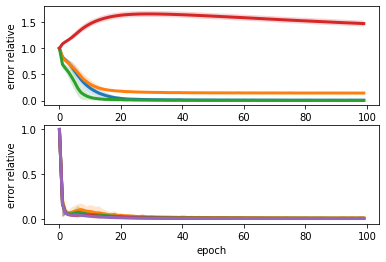

In [10]:
pr.plot_split_perf(rnn_folder='models/75-25_SplitLoss_Xmodels/200epochs')

# Load saved models

In [264]:
## Load all previously trained training runs

agg_conv, agg_score, agg_decoder_mat, agg_weights = {}, {}, {}, {}
folder_dict = {50: 'models/50-50_100models/', 75: 'models/75-25_100models/',
               90: 'models/90-10_100models/', 60: 'models/60-40_100models/',
               100:'models/100-0_100models/'}
folder_dict = {kk: folder_dict[kk] for kk in np.sort(list(folder_dict.keys()))}
folder_dict['MNM_acc'] = 'models/75-25_MNM_Xmodels/accumulate/'
folder_dict['MNM_nonacc'] = 'models/75-25_MNM_Xmodels/non-accumulate/'
for kk, vv in folder_dict.items():
    agg_conv[kk] = bp.aggregate_convergence(model_folder=vv)
    agg_score[kk] = bp.aggregate_score_mats(model_folder=vv)
    agg_decoder_mat[kk] = bp.aggregate_decoders(model_folder=vv)
    agg_weights[kk] = bp.aggregate_weights(model_folder=vv, weight='U')

<Figure size 720x1296 with 0 Axes>

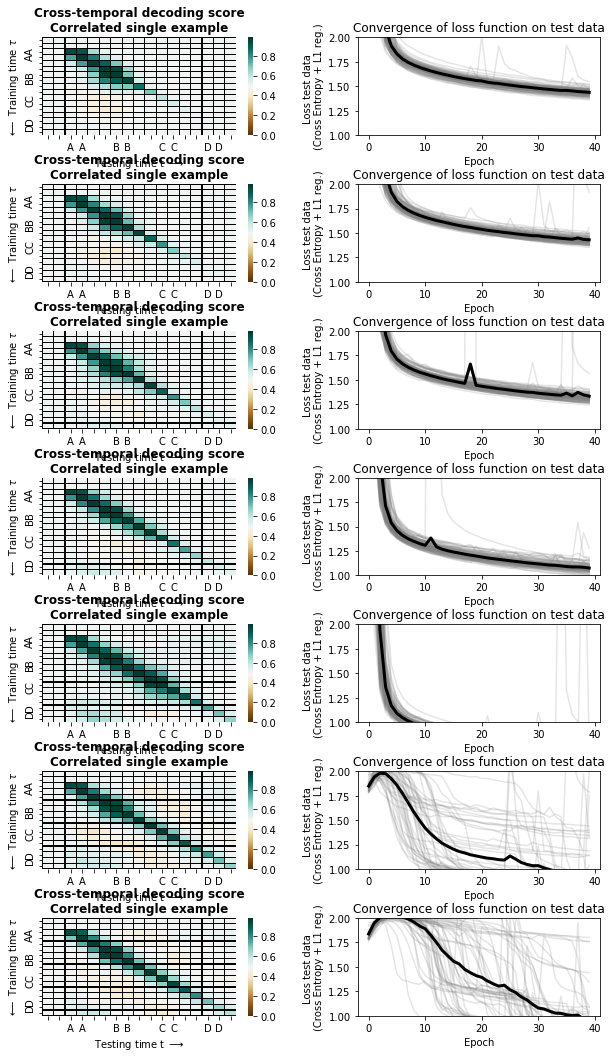

In [266]:
## Plot average matrix & convergences of all

plt.rcParams['figure.figsize'] = (10, 18)
plt.subplots_adjust(hspace=0.6)
fig, ax_agg = plt.subplots(len(folder_dict), 2)
for i_ax, kk in enumerate(list(agg_conv.keys())):
    model_selection = np.arange(agg_score[kk].shape[0])
#     model_selection = agg_score[kk][:, 11, 6] < 0.4
#     plot_mat = np.mean(np.abs(agg_score[kk][model_selection, :, :] - 0.5) + 0.5, 0)
    plot_mat = np.mean(agg_score[kk][model_selection, :, :], 0)
    pr.plot_decoder_crosstemp_perf(score_matrix=plot_mat, 
                                   ax=ax_agg[i_ax][0], ticklabels=double_time_labels_blank[:-1])

    ax_agg[i_ax][1].plot(agg_conv[kk]['test'][:100, :].T, alpha=0.2, c='grey')
    ax_agg[i_ax][1].plot(np.mean(agg_conv[kk]['test'], 0), linewidth=3, c='k')
    ax_agg[i_ax][1].set_ylim([1, 2]); 
    ax_agg[i_ax][1].set_ylabel('Loss test data \n(Cross Entropy + L1 reg.)')
    ax_agg[i_ax][1].set_xlabel('Epoch'); ax_agg[i_ax][1].set_title('Convergence of loss function on test data');
#     ax_agg[i_ax][1].text(s=f'Ratio Expected/Unexpected: {kk}/{100 - kk}. Average of {agg_score[kk].shape[0]} models',
#                          x=-46, y=2.15, fontdict={'weight': 'bold', 'fontsize': 13})
fig.subplots_adjust(hspace=0.5, wspace=0.3)
# plt.savefig('results/average_results_new.pdf', bbox_inches='tight')

Text(0.5, 1, 'Std CT decoding score')

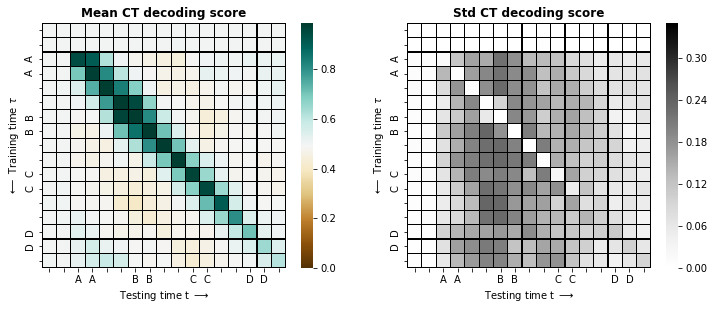

In [269]:
## Define different codes 
low_bound = 0.4  # rather arbitrary
high_bound = 0.6
ratio_use = 'MNM_nonacc'
agg_score_use = agg_score[ratio_use]
corr_names = {'low': 'anti-correlated', 'med': 'decorrelated',
              'high': 'correlated'}
train_times = np.arange(10, 13)
test_times = np.arange(4, 7)
summ_accuracy = agg_score_use[:, train_times, :][:, :, test_times].mean((1, 2))
inds_sel = {'low': np.where(summ_accuracy < low_bound)[0],
            'med': np.where(np.logical_and(summ_accuracy >= low_bound,
                                           summ_accuracy <= high_bound))[0],
            'high': np.where(summ_accuracy > high_bound)[0]}


plt.rcParams['figure.figsize'] = (12, 4.5)
ax_mean = plt.subplot(121)
pr.plot_decoder_crosstemp_perf(score_matrix=agg_score_use.mean(0), cmap_hm='BrBG',
                               ax=ax_mean, ticklabels=double_time_labels_blank[:-1])
plt.title('Mean CT decoding score', weight='bold')
ax_std = plt.subplot(122)
pr.plot_decoder_crosstemp_perf(score_matrix=agg_score_use.std(0), cmap_hm='Greys', v_max=0.35,
                               ax=ax_std, ticklabels=double_time_labels_blank[:-1])
plt.title('Std CT decoding score', weight='bold')
# plt.suptitle(f'Ratio Exp/Unexp: {ratio_use}/{100 - ratio_use}', weight='bold', y=1.05)

In [231]:
for kk, vv in inds_sel.items():
    print(kk, len(vv))

low 22
med 19
high 9


(array([ 0.,  0.,  1.,  1.,  2.,  3.,  4.,  9.,  6., 11.,  7.,  6.,  2.,
         1.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

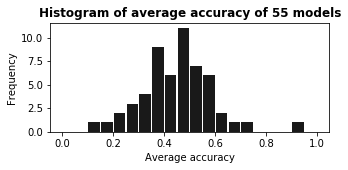

In [270]:
## Histogram of accuracy
plt.rcParams['figure.figsize'] = (5, 2)
plt.xlabel('Average accuracy')
plt.ylabel('Frequency'); plt.title(f'Histogram of average accuracy of {len(agg_score_use)} models', weight='bold')
plt.hist(summ_accuracy, color='k', bins=np.linspace(0, 1, 21), 
         rwidth=0.9, alpha=0.9)
# plt.savefig('figures/histogram_accuracy.pdf', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

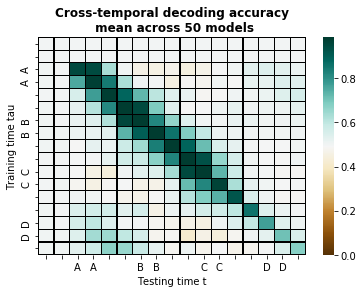

In [11]:
# single matrix

plt.rcParams['figure.figsize'] = (6, 4)
plt.subplots_adjust(hspace=0.6)
# fig, ax_agg = plt.subplots(len(folder_dict), 2)
fig, ax_agg = plt.subplots(1, 1)
# model_selection = np.ones(agg_score[kk].shape[0], dtype='bool')
# model_selection = agg_score_use[:, 10, 6] > 0.6
model_selection = inds_sel['high']
plot_mat = np.mean(agg_score[kk][model_selection, :, :], 0)
pr.plot_decoder_crosstemp_perf(score_matrix=plot_mat, 
                               ax=ax_agg, ticklabels=double_time_labels_blank[:-1])

#     ax_agg[1].plot(agg_conv[kk]['test'][:100, :].T, alpha=0.2, c='grey')
#     ax_agg[1].plot(np.mean(agg_conv[kk]['test'], 0), linewidth=3, c='k')
#     ax_agg[1].set_ylim([1, 2]); 
#     ax_agg[1].set_ylabel('Loss test data \n(Cross Entropy + L1 reg.)')
#     ax_agg[1].set_xlabel('Epoch'); ax_agg[1].set_title('Convergence of loss function on test data');
#     ax_agg[1].text(s=f'Ratio Expected/Unexpected: {kk}/{100 - kk}. Average of {agg_score[kk].shape[0]} models',
#                          x=-46, y=2.15, fontdict={'weight': 'bold', 'fontsize': 13})
fig.subplots_adjust(hspace=0.5, wspace=0.3)
ax_agg.set_title(f'Cross-temporal decoding accuracy\n mean across {np.sum(model_selection > 0)} models', weight='bold');
# plt.savefig('figures/decoding_matrix_high.pdf', bbox_inches='tight')

Mean: 0.43


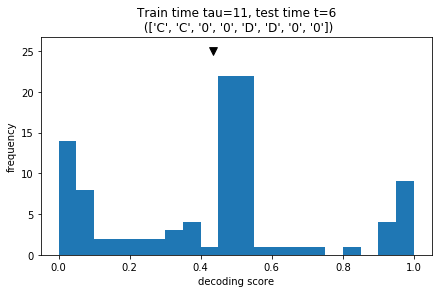

In [12]:
plt.rcParams['figure.figsize'] = (7, 4)
train_time = 11
test_time = 6
hist_arr = agg_score[90][:, train_time, test_time]
plt.hist(hist_arr, bins=np.linspace(0, 1, 21));
plt.scatter(np.mean(hist_arr), 25, marker='v', color='k', s=60)
print(f'Mean: {np.round(np.mean(hist_arr), 2)}')
plt.xlabel('decoding score'); plt.ylabel('frequency'); 
plt.title(f'Train time tau={train_time}, test time t={test_time}\n ({double_time_labels[train_time-1:]})');

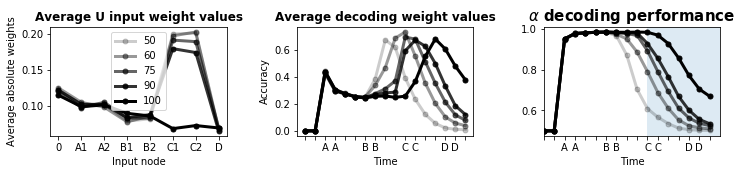

In [13]:
plt.rcParams['figure.figsize'] = (12, 2)
plt.subplots_adjust(wspace=0.4)
_ = pr.plot_summary_ratios(agg_weights=agg_weights, agg_decoder_mat=agg_decoder_mat,
                           agg_score=agg_score)

In [17]:
for ii, ll in enumerate(double_time_labels_blank[:-1]):
    print(ii, ll)

0 
1 
2 A
3 A
4 
5 
6 B
7 B
8 
9 
10 C
11 C
12 
13 
14 D
15 D
16 


## Count Stable & Switch cells
### Divided into AC/DC/C codes.

In [15]:
n_stable_arr, n_switch_arr = {}, {}
for key, inds_selection in inds_sel.items():  # loop through different codes and their selections 
    n_stable_arr[key], n_switch_arr[key] = [], []
    print(f'=------\n{key}\n-----')
    for i_rnn, ind_rnn in enumerate(inds_selection):
        rnn_name = list_rnns[ind_rnn]
        with open(rnn_folder + rnn_name, 'rb') as f:
            rnn = pickle.load(f)  # load RNN 
        _, __, forw  = bp.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5, sparsity_c=0.1)
        n_st_sw = ru.find_stable_switch_neurons_activity(forw_mat=forw, diff_th=0.5)[0]  # find st & Sw
        n_stable_arr[key].append(n_st_sw[0])  # unpack
        n_switch_arr[key].append(n_st_sw[1])
        
sum_stable = [np.mean(val) for _, val in n_stable_arr.items()]
sum_switch = [np.mean(val) for _, val in n_switch_arr.items()]
norm_sum_stable = [x / np.sum(sum_stable) for x in sum_stable]
norm_sum_switch = [x / np.sum(sum_switch) for x in sum_switch]


=------
low
-----


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: Conver

=------
med
-----


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: Conver

=------
high
-----


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: Conver

/home/thijs/repos/rotation/plot_routines.py:232: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def plot_stable_switch_bar_diagram(stable_list, switch_list, ax=plt.subplot(111), bar_width=0.35,


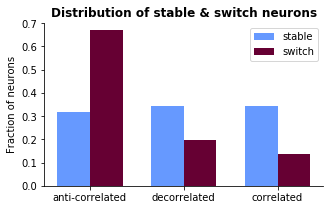

In [24]:
plt.rcParams['figure.figsize'] = (5, 3)
_ = pr.plot_stable_switch_bar_diagram(stable_list=norm_sum_stable, switch_list=norm_sum_switch)

## Plot single example

In [391]:
np.intersect1d(np.arange(5), np.arange(3, 8))

array([3, 4])

In [401]:
rnn_folder_dict = {'prediction_only': 'models/75-25_100models/', 
                   'mnm_acc': '/home/thijs/repos/rotation/models/75-25_MNM_Xmodels/accumulate/',
                   'mnm_nonacc': '/home/thijs/repos/rotation/models/75-25_MNM_Xmodels/non-accumulate/'}
total_rnns = 0
for key, rnn_folder in rnn_folder_dict.items():
    list_rnns = [x for x in os.listdir(rnn_folder) if x[-5:] == '.data']
    total_rnns += len(list_rnns)  
    
df_switch = pd.DataFrame({**{xx: np.zeros(total_rnns) for xx in ['ct_score', 'n_stable', 'n_switch', 
                                                                 'n_m_st', 'n_m_sw', 'n_nm_st', 'n_nm_sw']}, 
                          **{x: np.zeros(total_rnns, dtype='object') for x in ['rnn_name', 'rnn_type', 'folder_name']}})
i_rnn = 0
for key, rnn_folder in rnn_folder_dict.items():
    list_rnns = [x for x in os.listdir(rnn_folder) if x[-5:] == '.data']
    for rnn_name in tqdm(list_rnns):
        rnn = ru.load_rnn(rnn_name=os.path.join(rnn_folder, rnn_name))
        _, __, forw  = bp.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5, sparsity_c=0.1, bool_train_decoder=False)
        df_switch['ct_score'].iat[i_rnn] = np.mean(rnn.decoding_crosstemp_score['alpha'][train_times, :][:, test_times])
        (n_stable_neurons, n_switch_neurons), (stable_inds, switch_inds) = ru.find_stable_switch_neurons_activity(forw_mat=forw, diff_th=0.5)
        df_switch['n_stable'].iat[i_rnn] = n_stable_neurons
        df_switch['n_switch'].iat[i_rnn] = n_switch_neurons
        df_switch['rnn_name'].iat[i_rnn] = rnn_name
        df_switch['rnn_type'].iat[i_rnn] = key
        df_switch['folder_name'].iat[i_rnn] = rnn_folder
        
        ## find number of stable and switch output neurons to M and NM 
        if 'mnm' in key:
            sign_weight_types = ru.connect_mnm_stsw(rnn=rnn, stable_inds=stable_inds, switch_inds=switch_inds, verbose=0) # find how many stable/switch neurons connect to M/NM output neurons and save below:
            df_switch['n_m_st'].iat[i_rnn] = sign_weight_types['match']['stable']
            df_switch['n_nm_st'].iat[i_rnn] = sign_weight_types['nonmatch']['stable']
            df_switch['n_m_sw'].iat[i_rnn] = sign_weight_types['match']['switch']
            df_switch['n_nm_sw'].iat[i_rnn] = sign_weight_types['nonmatch']['switch']
        i_rnn += 1
    


100%|██████████| 100/100 [02:36<00:00,  1.57s/it]

100%|██████████| 50/50 [02:07<00:00,  2.55s/it]

 12%|█▏        | 6/50 [00:12<01:33,  2.13s/it]


100%|██████████| 50/50 [01:53<00:00,  2.27s/it]


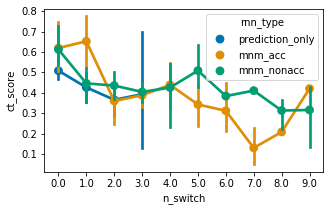

In [376]:
plt.rcParams['figure.figsize'] = (5, 3)
sns.pointplot(data=df_switch, x='n_switch', y='ct_score', hue='rnn_type')
# sns.barplot(data=df_switch, x='n_switch', hue='rnn_type')

In [432]:
sns.color_palette('Set1', n_colors=2)

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)]

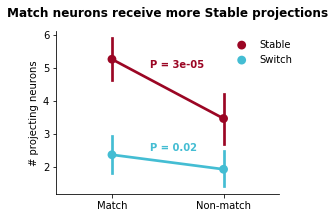

In [459]:
plt.rcParams['figure.figsize'] = (4, 3)
_ = pr.plot_mnm_stsw(df_stable_switch=df_switch, rnn_type='mnm_acc')

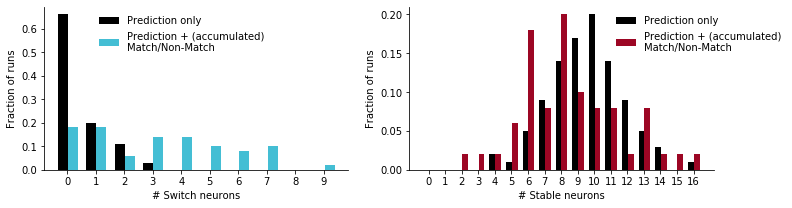

In [476]:
plt.rcParams['figure.figsize'] = (12, 3)
ax_stable = plt.subplot(122)
ax_switch = plt.subplot(121)

_ = pr.plot_bar_switch_rnn_types(df_stable_switch=df_switch, neuron_type='n_stable',
                                 rnn_types_list=['prediction_only', 'mnm_acc'], ax=ax_stable)
_ = pr.plot_bar_switch_rnn_types(df_stable_switch=df_switch, neuron_type='n_switch',
                                 rnn_types_list=['prediction_only', 'mnm_acc'], ax=ax_switch)
plt.savefig('tmp.pdf', bbox_to_inches='tight')

### Difference ratios

In [59]:
rmse_symm_dict = {}
low_mean_dict = {}
for key_ratio, rnn_folder in tqdm(folder_dict.items()):
    list_rnns = [x for x in os.listdir(rnn_folder) if x[-5:] == '.data']
    rmse_symm_dict[key_ratio] = np.zeros(len(list_rnns))
    low_mean_dict[key_ratio] = np.zeros(len(list_rnns))
    for i_rnn, rnn_name in enumerate(list_rnns):
        with open(rnn_folder + rnn_name, 'rb') as f:
            rnn = pickle.load(f)
        total_rmse, low_tri_mean = ru.rmse_matrix_symm(matrix=rnn.decoding_crosstemp_score['alpha'][:, :12][:12, :])
        rmse_symm_dict[key_ratio][i_rnn] = total_rmse
        low_mean_dict[key_ratio][i_rnn] = low_tri_mean

100%|██████████| 5/5 [00:00<00:00, 10.68it/s]


In [64]:
print([(kk, np.round(np.mean(vv), 2)) for kk, vv in low_mean_dict.items()])
# print(rms)

[(50, 0.15), (60, 0.17), (75, 0.19), (90, 0.2), (100, 0.24)]


In [62]:
tmp = np.arange(16).reshape((4, 4))
ru.rmse_matrix_symm(tmp)

(2.23606797749979, 7.666666666666667)

### Individual examples

In [18]:
kkk = 0

average acccuracy in train/test area: 0.994


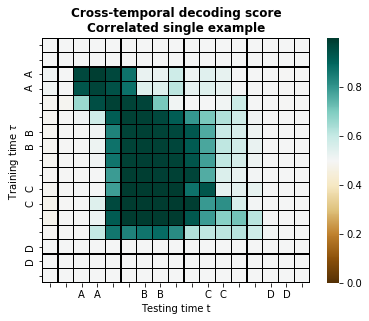

In [32]:
rnn_folder = 'models/75-25_100models/'
list_rnns = [x for x in os.listdir(rnn_folder) if x[-5:] == '.data']
# OLD
# print(kkk)
# rnn_name = list_rnns[inds_sel['med'][15]]
# rnn_name = list_rnns[inds_sel['low'][6]]
# rnn_name = list_rnns[inds_sel['high'][2]]

## NEW
# rnn_name = list_rnns[inds_sel['med'][1]]  # used ot be 21
# rnn_name = list_rnns[inds_sel['low'][3]]
rnn_name = list_rnns[inds_sel['high'][3]]

rnn_name_dict = {'high': list_rnns[inds_sel['high'][3]],
                 'med': list_rnns[inds_sel['med'][1]], 
                 'low': list_rnns[inds_sel['low'][3]]}

## Change:
# kkk += 1
# print(kkk)
# rnn_name = list_rnns[kkk]

with open(rnn_folder + rnn_name, 'rb') as f:
    rnn = pickle.load(f)
print('average acccuracy in train/test area:', np.round(rnn.decoding_crosstemp_score['alpha'][train_times, :][:, test_times].mean(),3 ))

plt.rcParams['figure.figsize'] = (6, 4.5)
_ = pr.plot_decoder_crosstemp_perf(score_matrix=rnn.decoding_crosstemp_score['alpha'], 
                               ax=plt.subplot(111), 
                               ticklabels=double_time_labels_blank[:-1])

In [141]:
_, __, forw  = bp.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5, sparsity_c=0.1)
labels_use_1 = np.array([x[0] == '1' for x in forw['labels_test']])
labels_use_2 = np.array([x[0] == '2' for x in forw['labels_test']])
print('Accuracy matrix: \n', np.round(rnn.decoding_crosstemp_score['alpha'][train_times, :][:, test_times], 2))
tmp  = ru.find_stable_switch_neurons_activity(forw_mat=forw, diff_th=0.5)
print('(stable, switch): ', tmp[0])

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


NameError: name 'train_times' is not defined

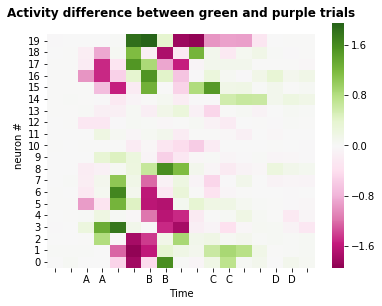

In [142]:
plt.rcParams['figure.figsize'] = (6, 4.5)
# plt.rcParams['font.size'] = 10
ax_hm = plt.subplot(111)
ol = pr.plot_raster_trial_average(forw=forw, ax=ax_hm)

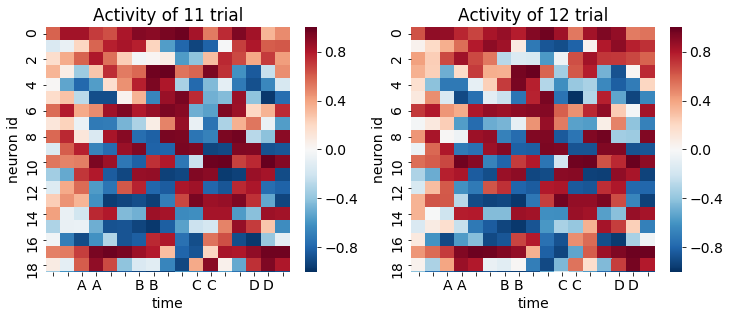

In [80]:
plt.rcParams['figure.figsize'] = (12, 4.5)

n_trial_1 = 1
n_trial_2 = 2
              
ax_single_trial = {0: plt.subplot(121), 1: plt.subplot(122)}
        
for i_plot, nn in enumerate([n_trial_1, n_trial_2]):
    _ = pr.plot_trial_activity(forw=forw, neuron_order=ol, ax=ax_single_trial[i_plot], n_trial=nn)

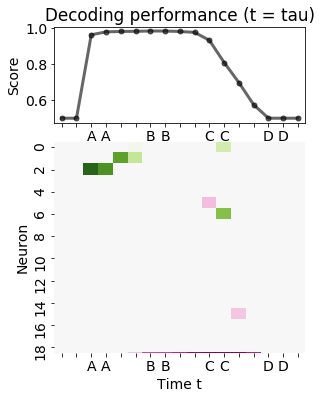

In [81]:
plt.rcParams['figure.figsize'] = (4.5, 6)
_ = pr.plot_dynamic_decoding_axes(rnn=rnn, neuron_order=ol)

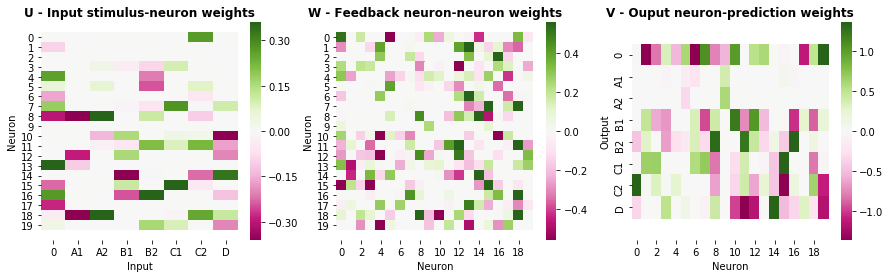

In [68]:
plt.rcParams['figure.figsize'] = (15, 4)
_ = pr.plot_all_UWV(rnn_model=rnn, freq_labels=freq_labels, weight_order=None)

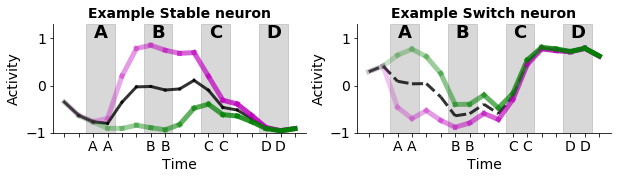

In [95]:
plt.rcParams['figure.figsize'] = (10, 2)
plt.rcParams['font.size'] = 14
ax_diff_single = {}  
activity_1, activity_2 = {}, {}
mean_ls_dict = {0: '-', 1: '--'}
neuron_selection = {'low': [19, 2], 'med': [0, 5], 'high': [19, 2]}
title_selection = {'low': ['Switch neuron 1', 'Switch neuron 2'],
                   'med': ['Stable neuron ', 'Switch neuron'],
                   'high': ['Stable neuron 1', 'Stable neuron 2']}
fn_dict = {'low': 'switch-switch', 'med': 'stable-switch', 'high':'stable-stable'}

curr_sel = 'high'
save_fig = False

for i_plot, n_neuron in enumerate([ol[neuron_selection[curr_sel][xx]] for xx in range(2)]):
    ax_diff_single[i_plot] = plt.subplot(1, 2, i_plot + 1)
    activity_1[n_neuron] = forw['test'][labels_use_1, :, :][:, :, n_neuron].mean(0)
    activity_2[n_neuron] = forw['test'][labels_use_2, :, :][:, :, n_neuron].mean(0)
    ax_diff_single[i_plot] = pr.plot_neuron_diff(ax_select=ax_diff_single[i_plot], 
                                              act_1=activity_1[n_neuron], 
                                              act_2=activity_2[n_neuron],
                                              mean_ls=mean_ls_dict[i_plot])
    if i_plot == 0:
        ax_diff_single[i_plot].set_title('Example Stable neuron', weight='bold',
                                         fontsize=14)
    if i_plot == 1:
        ax_diff_single[i_plot].set_title('Example Switch neuron', weight='bold',
                                         fontsize=14)
if save_fig:
        plt.savefig(f'figures/example_{curr_sel}_neurons_{fn_dict[curr_sel]}.pdf', bbox_inches='tight')

In [49]:
np.asarray(double_time_labels_blank[:-1])[np.arange(2, 8)]

array(['A', 'A', '', '', 'B', 'B'], dtype='<U1')

sens -0.37 -0.19
mem -0.05 0.2
sens 0.37 0.19
mem 0.05 -0.2


/home/thijs/repos/rotation/plot_routines.py:239: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def plot_alpha_beta_performance(alpha_perf, beta_perf, ax=plt.subplot(111),
/home/thijs/repos/rotation/plot_routines.py:259: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def plot_stable_switch_bar_diagram(stable_list, switch_list, ax=plt.subplot(111), bar_width=0.35,
/home/thijs/repos/rotation/plot_routines.py:333: MatplotlibDeprecati

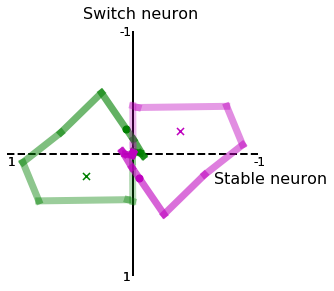

In [57]:
plt.rcParams['figure.figsize'] = (4.5, 4.5)
ax_ss = plt.subplot(111)
_ = pr.plot_two_neuron_state_space(activity_1=activity_1, activity_2=activity_2, 
                                   mean_ls_dict=mean_ls_dict, save_fig=False, ax=ax_ss,
                                   fig_name=f'figures/example_{curr_sel}_statespace_{fn_dict[curr_sel]}.pdf')

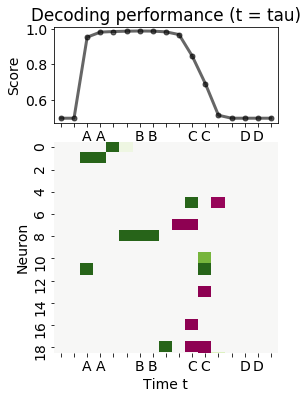

In [246]:
plt.rcParams['figure.figsize'] = (4, 6)
_, __ = pr.plot_dynamic_decoding_axes(rnn=rnn, ticklabels=double_time_labels_blank[:-1])
plt.savefig('figures/example_low_decodingweights.pdf', bbox_inches='tight')

Final test performance: 1.268


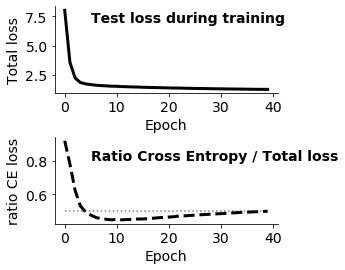

In [93]:
## Plot train/test loss during training
plt.rcParams['figure.figsize'] = (4, 4)
plt.subplots_adjust(hspace=0.5)
_ = pr.plot_convergence_rnn(rnn=rnn, verbose=True)

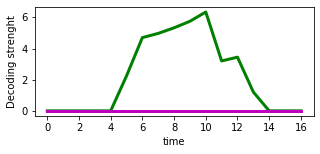

In [90]:
plt.rcParams['figure.figsize'] = (5, 2)

_  = pr.plot_time_trace_1_decoding_neuron(rnn=rnn)

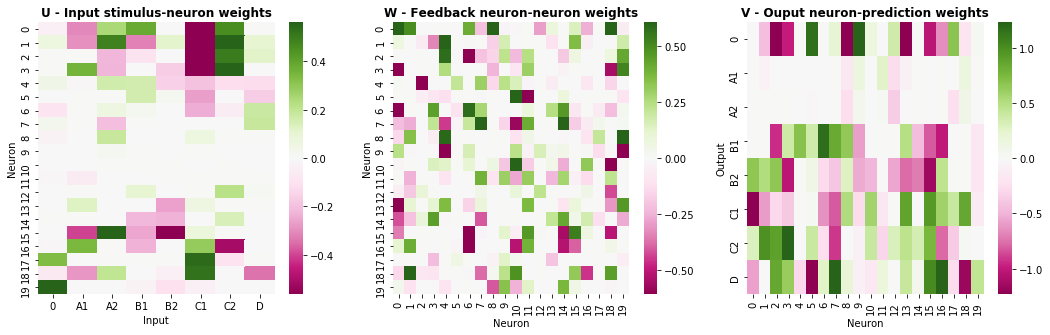

In [89]:

plt.rcParams['figure.figsize'] = (18, 5)
w_order = pr.opt_leaf(w_mat=rnn.lin_input, dim=0)
_ = pr.plot_all_UWV(rnn_model=rnn, freq_labels=freq_labels, weight_order=w_order)

# Compiled figures

In [469]:
font_size = 10
plt.rcParams['font.size'] = font_size
plt.rcParams['axes.autolimit_mode'] = 'data' # default: 'data'
params = {'legend.fontsize': font_size,
         'axes.labelsize': font_size,
         'axes.titlesize': font_size,
         'xtick.labelsize': font_size,
         'ytick.labelsize': font_size}
plt.rcParams.update(params)

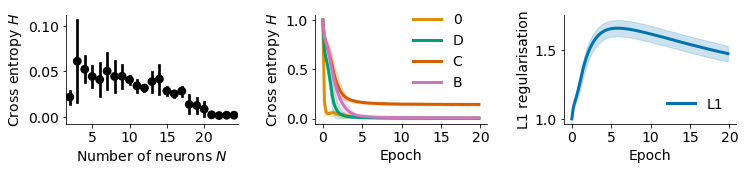

In [412]:
plt.rcParams['figure.figsize'] = (12, 2)
# font size 14
_ = pr.plot_convergence_stats()
plt.savefig('figures/thesis/fig1_C.svg', bbox_inches='tight')

In [413]:
sc.Figure('19.5cm', '11.7cm',
          sc.Panel(sc.SVG('figures/thesis/fig1_AB.svg').scale(3).move(4, 4)),
          sc.Panel(sc.SVG('figures/thesis/fig1_C.svg').scale(1).move(-4, 265))
                  ).save('figures/thesis/fig1_complete.svg')
ip.SVG('figures/thesis/fig1_complete.svg')

generating data with 0.8 train ratio, 0.75 expected ratio


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


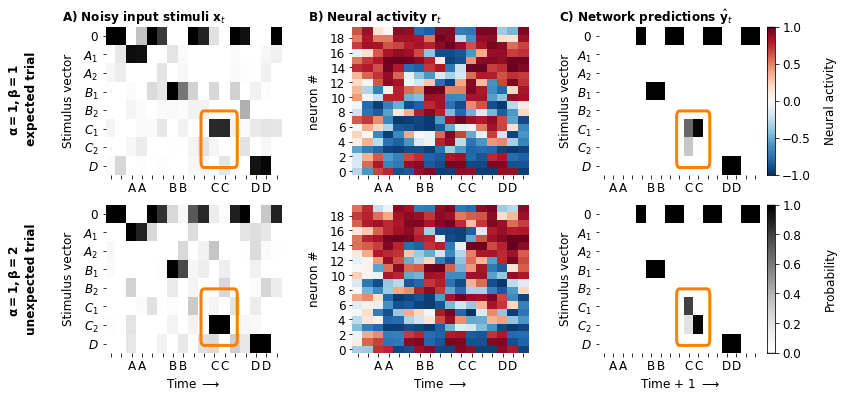

In [553]:
plt.rcParams['figure.figsize'] = (12, 6)
# font size 14
_ = pr.plot_prediction_example(rnn=rnn, plot_conv=False)
plt.savefig('figures/thesis/fig2.pdf', bbox_inches='tight')

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


<Figure size 864x720 with 0 Axes>

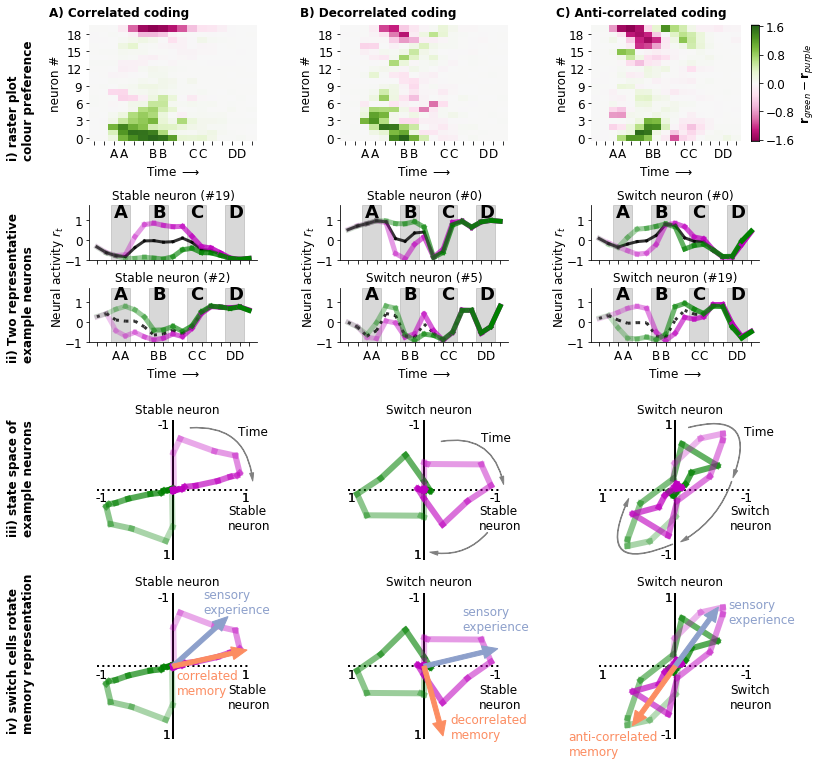

In [520]:
plt.rcParams['figure.figsize'] = (12, 10)
# font size 12
plt.subplots_adjust(hspace=0.4, wspace=0.3 )
pr.plot_multiple_rnn_properties(rnn_name_dict=rnn_name_dict, 
                                rnn_folder=rnn_folder, fontsize=font_size)
plt.savefig('figures/thesis/fig3.pdf', bbox_inches='tight')


<Figure size 864x324 with 0 Axes>

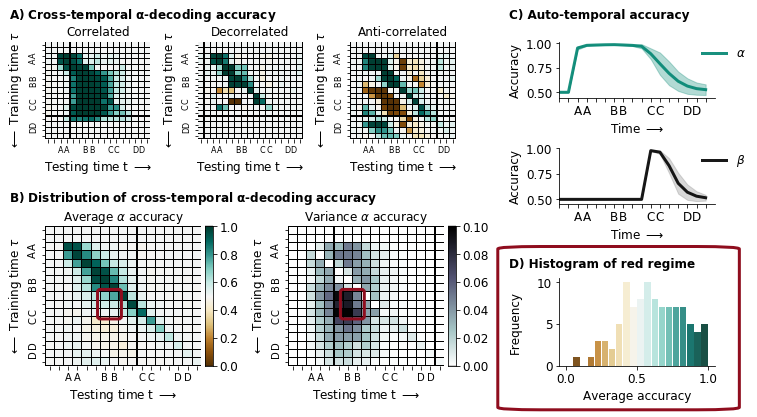

In [549]:
plt.rcParams['figure.figsize'] = (12, 4.5)
# font size 10
plt.subplots_adjust(wspace=0.5, hspace=1)
pr.plot_distr_networks(rnn_name_dict=rnn_name_dict, fontsize=font_size)
plt.savefig('figures/thesis/fig4.pdf', bbox_inches='tight')

(0.5, 1.0)
(0, 0.5)
(0, 0.5)


[-5.0, 0.0, 5.0, 10.0, 15.0, 20.0]

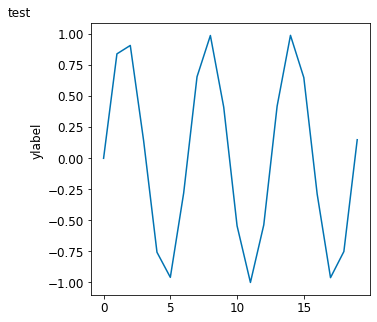

In [546]:
plt.rcParams['figure.figsize'] = (5, 5)
ax_tmp = plt.subplot(111)
ax_tmp.plot(np.sin(np.arange(20)))
ax_tmp.set_ylabel('ylabel')
ax_tmp.set_title('test')

ax_tmp.yaxis.label.set_ha('left')
ax_tmp.title.set_ha('left')

print(ax_tmp.title.get_position())
print(ax_tmp.yaxis.label.get_position())
ax_tmp.title.set_position((-0.3, 1))
ax_tmp.yaxis.label.set_va('bottom')
print(ax_tmp.yaxis.label.get_position())

# ax_tmp.set_xticklabels(ax_tmp.get_xticklabels(), fontsize=30)
list(ax_tmp.get_xticks())
# ax_tmp.yaxis.set_label_coords(x=-0.3, y=0.5)